# Data Exploration

In [3]:
import pickle
import pandas as pd
import numpy as np

In [4]:
import pandas as pd
import datetime as dt
import numpy as np

import pandas as pd
import datetime as dt
import numpy as np

class TrainDataProcessor:
    """Processes Train data, using train data as a warm start, and prepares it for inference."""

    def __init__(self, train, revealed_targets, client, historical_weather,
                 forecast_weather, electricity_prices, gas_prices):
        self.test_orig_dfs = self.get_test_orig_dfs([train.copy(), revealed_targets.copy(), client.copy(), historical_weather.copy(),
                 forecast_weather.copy(), electricity_prices.copy(), gas_prices.copy()])
        self.train = self.init_train(train)
        self.revealed_targets = self.init_revealed_targets(revealed_targets)
        self.client = self.init_client(client)
        self.weather_mapping = self.init_weather_mapping()
        self.historical_weather = self.init_historical_weather(historical_weather)
        self.forecast_weather = self.init_forecast_weather(forecast_weather)
        self.electricity_prices = self.init_electricity(electricity_prices)
        self.gas_prices = self.init_gas_prices(gas_prices)
        
        self.df_all_cols = self.join_data(self.train, self.revealed_targets, self.client, self.historical_weather, self.forecast_weather, self.electricity_prices, self.gas_prices)
        self.df = self.remove_cols(self.df_all_cols)
        
    def get_test_orig_dfs(self, dfs):
        for i, df in enumerate(dfs):
            if 'datetime' in df.columns:
                df['datetime'] = pd.to_datetime(df.datetime)
                col = 'datetime'
            if 'prediction_datetime' in df.columns:
                df['prediction_datetime'] = pd.to_datetime(df.prediction_datetime)
                col = 'prediction_datetime'
            if 'forecast_date' in df.columns:
                df['forecast_date'] = pd.to_datetime(df['forecast_date'])
                col = 'forecast_date'
            if 'forecast_datetime' in df.columns:
                df['forecast_datetime'] = pd.to_datetime(df['forecast_datetime'])
                col = 'forecast_datetime'
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df.date).dt.date
                col = 'date'

            test_date = df[col].iloc[-1]  # Assuming test is a DataFrame
            start_date = test_date - pd.Timedelta(days=14)
            historical_subset = df[df[col] >= start_date]
            dfs[i] = historical_subset
        return dfs
        
    def init_train(self, df):
        """Prepares the training data for model training."""
        try:
            df['datetime'] = pd.to_datetime(df.datetime)
        except Exception as e:
            df['datetime'] = pd.to_datetime(df.prediction_datetime)
        df['date'] = df.datetime.dt.date
            
        # df = self.get_data_block_id(df, 'datetime')
        return df
    
    def add_electricity_lag_features(self, df):
        """Chatgpt summary:
        Enhances a DataFrame with electricity price lag features:
        - Sets 'datetime' as Index for time series analysis.
        - Calculates rolling 7-day mean price, lagged by one day.
        - Computes rolling 7-day mean for same hour, lagged.
        - Adds column for yesterday's price, shifted by 24 hours.
        - Calculates 24-hour rolling average of electricity prices.
        - Resets index and drops 'forecast_date', 'origin_date', 'hour'.
        """
        ##### mean from entire last week
        df.set_index('datetime', inplace=True)
        # Use rolling to calculate mean price of the last week
        # The window is 7 days, min_periods can be set as per requirement
        # 'closed' determines which side of the interval is closed; it can be 'right' or 'left'
        df['mean_euros_per_mwh_last_week'] = df['euros_per_mwh'].rolling(window='7D', min_periods=1, closed='right').mean()
        # Shift the results to align with the requirement of lagging
        df['mean_euros_per_mwh_last_week'] = df['mean_euros_per_mwh_last_week'].shift()
        
        ##### mean from last week this hour only
        # Extract hour from datetime
        df['hour'] = df.index.hour

        # Group by hour and apply rolling mean for each group
        hourly_groups = df.groupby('hour')
        dff = hourly_groups['euros_per_mwh'].rolling(window='7D', min_periods=1, closed='right').mean()#.shift()#.reset_index(level=0, drop=True)
        dff = dff.reset_index().set_index('datetime').groupby('hour')['euros_per_mwh'].shift()
        dff = dff.rename('mean_euros_per_mwh_same_hour_last_week')
        df = df.join(dff)
        #### yesterday's power price
        df['yesterdays_euros_per_mwh'] = df['euros_per_mwh'].shift(24)
        
        ### 24h average
        # Calculate the 24-hour rolling average
        df['euros_per_mwh_24h_average_price'] = df['euros_per_mwh'].rolling(window=24, min_periods=1).mean()

        # Resetting the index if needed
        df.reset_index(inplace=True)
        df = df.drop(['forecast_date', 'origin_date', 'hour'], axis=1)
        return df

    def init_electricity(self, df):
        ## LAG = 1 Day
        ## Move forecast datetime ahead by 1 day
        ## change name to datetime
        df['datetime'] = pd.to_datetime(df['forecast_date'])
        df['datetime'] = df['datetime'] + dt.timedelta(days=1)
        # df = self.get_data_block_id(df, 'datetime')
        df = self.add_electricity_lag_features(df)
        return df
    
    def add_historical_weather_lag_features(self, df):
        """Chatgpt summary:
        Enhances a DataFrame with historical weather lag features:
        - Converts 'datetime' to Datetime object and sets as index.
        - Sorts data by 'datetime', 'latitude', 'longitude'.
        - Creates 'location_id' as a unique identifier for each location.
        - Filters for 10:00 AM entries and shifts features by 1 day.
        - Merges lagged features with original DataFrame.
        - Calculates mean and variance for weather features over the last 24 hours.
        - Merges these statistical summaries back into the original DataFrame.
        """
        ##### LATEST WEATHER
        def add_latest_weather(df):
            # Assuming df is your original DataFrame
            # Step 1: Convert datetime to a Datetime Object
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)

            # Step 2: Sorting the Data
            df.sort_values(by=['datetime', 'latitude', 'longitude'], inplace=True)

            # Step 3: Creating a Unique Identifier for each location
            df['location_id'] = df['latitude'].astype(str) + '_' + df['longitude'].astype(str)

            # Step 4: Filtering for 10:00 AM Entries
            df.reset_index(inplace=True)
            df_10am = df[df['datetime'].dt.hour == 10]
            df_10am.set_index('datetime', inplace=True)

            # Step 5: Shifting the Features by 1 day
            lagged_features = df_10am.groupby('location_id').shift(periods=1, freq='D')

            # Renaming columns to indicate lag
            lagged_features = lagged_features.add_suffix('_hw_lagged')
            lagged_features['location_id'] = lagged_features['location_id_hw_lagged']
            lagged_features.reset_index(inplace=True)
            lagged_features['date'] = lagged_features.datetime.dt.date

            df['date'] = df.datetime.dt.date
            return lagged_features
            # Step 6: Merging Lagged Features with Original DataFrame
            df = df.merge(lagged_features, on=['date', 'location_id'], how='left', suffixes=('', '_hw_lagged'))
            return df
        
        ##### mean from last day
        def add_24h_mean_var(df, weather_features):
            # Calculate the start and end times for each row
            df['start_time'] = pd.to_datetime(df['datetime'].dt.date) - pd.Timedelta(days=2) + pd.Timedelta(hours=11)
            df['end_time'] = pd.to_datetime(df['datetime'].dt.date) - pd.Timedelta(days=1) + pd.Timedelta(hours=10)
            df['time_code'] = df['start_time'].astype(str) +'_' + df['end_time'].astype(str) + '_' + df['latitude'].astype(str) + '_' + df['longitude'].astype(str)
            # print(df.time_code)

            # Create a helper column for grouping
            # If the time is before 10:00 AM, subtract a day
            df['group'] = df['datetime'].apply(lambda dt: dt if dt.time() >= pd.to_datetime('11:00').time() else dt - pd.Timedelta(days=1))
            df['group'] = df['group'].dt.date  # Keep only the date part for grouping
            df['group'] = (pd.to_datetime(df['group']) + pd.Timedelta(hours=11)).astype(str) + '_' + (pd.to_datetime(df['group']) + pd.Timedelta(days=1, hours=10)).astype(str) + '_' + df['latitude'].astype(str) + '_' + df['longitude'].astype(str)

            # Now group by this new column
            grouped = df.groupby('group')
            means = grouped[weather_features].mean()
            variances = grouped[weather_features].var()

            # Merge means and variances into the original DataFrame
            my_df = df.merge(means, left_on='time_code', right_on='group', suffixes=('', '_hw_means'), how='left')
            my_df = my_df.merge(variances, left_on='time_code', right_on='group', how='left', suffixes=('', '_hw_variances'))

            return my_df

        df['datetime'] = pd.to_datetime(df['datetime'])
        weather_features = df.columns.drop(['datetime', 'latitude', 'longitude'])

        # Apply the function
        df = add_24h_mean_var(df, weather_features)       
        latest = add_latest_weather(df)
        df = df.merge(latest, on=['date', 'location_id'], how='left', suffixes=('', '_hw_lagged'))
        
        return df

    def init_historical_weather(self, df):
        ## LAG: From 11:00 AM 2 days ago to 10:00 AM 1 day ago
        ## What to do? Give most recent weather forecast? Give average over the last day?
        """
        Processes the historical weather data.
        """
        df['datetime'] = pd.to_datetime(df.datetime)
        
        df = self.add_historical_weather_lag_features(df)
        
        df = df.merge(self.weather_mapping, how='inner', on=('latitude', 'longitude'))
        return df

    def init_forecast_weather(self, df):
        """Chatgpt summary:
        Processes forecast weather data:
        - Converts 'forecast_datetime' to 'datetime' and adjusts it forward by 1 day.
        - Filters data to keep records with 'hours_ahead' between 22 and 45.
        - Merges with a weather mapping based on 'latitude' and 'longitude'.
        """
        ## LAG: DON't ADJUST
        ##      The forecast is from yesterday, but can forecast today, which is 22 hours ahead
        ## Drop any columns where:
        ##                        hours_ahead < 22 and hours_ahead > 45
        ## Then rename forecast_datetime to datetime and join on datetime
        """
        Processes the forecast weather data.
        """
        df['datetime'] = pd.to_datetime(df['forecast_datetime'])
        # keep only datetimes from our relevant period
        df = df[(df['hours_ahead'] < 46) & (df['hours_ahead'] > 21)]
        df['datetime'] = df['datetime'] + dt.timedelta(days=1)
        df = df.merge(self.weather_mapping, how='inner', on=('latitude', 'longitude'))
        return df
    
    def add_gas_prices_lag_features(self, df):
        """Chatgpt summary
        Augments a DataFrame with rolling average lag features for gas prices:
        - Converts 'date' to Datetime object and sets as index.
        - Sorts DataFrame by date.
        - Calculates rolling averages for lowest and highest gas prices over 3, 7, and 14 days.
        - Resets the index to include 'date' as a column again.
        """
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

        # Sort the DataFrame by date, if it's not already sorted
        df.sort_index(inplace=True)

        # Calculate rolling averages for different time windows
        df['lowest_price_3d_avg'] = df['lowest_price_per_mwh'].rolling(window=3).mean()
        df['highest_price_3d_avg'] = df['highest_price_per_mwh'].rolling(window=3).mean()

        df['lowest_price_7d_avg'] = df['lowest_price_per_mwh'].rolling(window=7).mean()
        df['highest_price_7d_avg'] = df['highest_price_per_mwh'].rolling(window=7).mean()

        df['lowest_price_14d_avg'] = df['lowest_price_per_mwh'].rolling(window=14).mean()
        df['highest_price_14d_avg'] = df['highest_price_per_mwh'].rolling(window=14).mean()

        # Reset the index if you want the 'date' column back
        df.reset_index(inplace=True)
        return df

    def init_gas_prices(self, df):
        ## LAG: 1 DAY
        ## Predictions are made from 2 days ago and predict for yesterday
        ## add one day to forecast_date
        ## Rename forecast_date to date, join on date
        """
        Processes the gas prices data.
        Implement the logic to handle gas prices data processing here.
        """
        df['date'] = pd.to_datetime(df['forecast_date']).dt.date
        df['date'] = df['date'] + dt.timedelta(days=1)
        df = self.add_gas_prices_lag_features(df)
        return df
    
    def add_revealed_target_features(self, df):
        """Chatgpt summary:
        Enhances DataFrame with rolling average target features:
        - Converts 'datetime' to Datetime object, extracts 'hour' and 'day' of week.
        - Sets 'datetime' as index.
        - Calculates various rolling averages of 'target' based on different groupings:
          - 24-hour rolling average by county, business status, product type, and consumption status.
          - 7-day hourly rolling average by county, business status, product type, consumption status, and hour.
          - 4-week rolling average by county, business status, product type, consumption status, hour, and day.
          - Similar calculations considering all product types.
        - Drops 'hour' and 'day' columns after processing.
        """
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['hour'] = df.datetime.dt.hour
        df['day'] = df.datetime.dt.dayofweek
        df.set_index('datetime', inplace=True)

        window_size = 7
        # Group by the specified columns and then apply the rolling mean
        grouped = df.groupby(['county', 'is_business', 'product_type', 'is_consumption'])
        df['target_rolling_avg_24h'] = grouped['target'].transform(lambda x: x.rolling(window=24, min_periods=1).mean())

        grouped = df.groupby(['county', 'is_business', 'product_type', 'is_consumption', 'hour'])
        df['target_rolling_avg_hour_7d'] = grouped['target'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

        grouped = df.groupby(['county', 'is_business', 'product_type', 'is_consumption', 'hour', 'day'])
        df['target_rolling_avg_hour_hour_day_4w'] = grouped['target'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

        grouped = df.groupby(['county', 'is_business', 'is_consumption'])
        df['target_rolling_allp_avg_24h'] = grouped['target'].transform(lambda x: x.rolling(window=24, min_periods=1).mean())

        grouped = df.groupby(['county', 'is_business', 'is_consumption', 'hour'])
        df['target_rolling_allp_avg_hour_7d'] = grouped['target'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

        grouped = df.groupby(['county', 'is_business', 'is_consumption', 'hour', 'day'])
        df['target_rolling_allp_avg_hour_hour_day_4w'] = grouped['target'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
        
        df = df.drop(['hour', 'day'], axis=1)

        return df
    
    def init_revealed_targets(self, df):
        df['datetime'] = pd.to_datetime(df.datetime)
        df['datetime'] = df['datetime'] + dt.timedelta(days=2)
        df = self.add_revealed_target_features(df)
        return df
    
    def init_client(self, df):
        ## LAG: 2 days
        ## Add 2 days to date, join on date
        df['date'] = pd.to_datetime(df.date).dt.date
        df['date'] = df['date'] + dt.timedelta(days=2)
        # df = self.get_data_block_id(df, 'date')
        return df

    def init_weather_mapping(self):
        # https://www.kaggle.com/code/tsunotsuno/enefit-eda-baseline/notebook#Baseline
        county_point_map = {
            0: (59.4, 24.7), # "HARJUMAA"
            1 : (58.8, 22.7), # "HIIUMAA"
            2 : (59.1, 27.2), # "IDA-VIRUMAA"
            3 : (58.8, 25.7), # "JÄRVAMAA"
            4 : (58.8, 26.2), # "JÕGEVAMAA"
            5 : (59.1, 23.7), # "LÄÄNE-VIRUMAA"
            6 : (59.1, 23.7), # "LÄÄNEMAA"
            7 : (58.5, 24.7), # "PÄRNUMAA"
            8 : (58.2, 27.2), # "PÕLVAMAA"
            9 : (58.8, 24.7), # "RAPLAMAA"
            10 : (58.5, 22.7),# "SAAREMAA"
            11 : (58.5, 26.7),# "TARTUMAA"
            12 : (58.5, 25.2),# "UNKNOWNN" (center of the map)
            13 : (57.9, 26.2),# "VALGAMAA"
            14 : (58.2, 25.7),# "VILJANDIMAA"
            15 : (57.9, 27.2) # "VÕRUMAA"
        }
        # Convert the dictionary to a list of tuples
        data = [(county_code, lat, lon) for county_code, (lat, lon) in county_point_map.items()]

        # Create DataFrame
        df = pd.DataFrame(data, columns=['county', 'latitude', 'longitude'])
        
        return df
    
    def add_date_features(self, df):
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
        df['quarter'] = df['datetime'].dt.quarter
        df['day_of_week'] = df['datetime'].dt.day_of_week
        df['day_of_year'] = df['datetime'].dt.dayofyear
        df['week_of_year'] = df['datetime'].dt.isocalendar().week
        df['is_weekend'] = df['datetime'].dt.day_of_week >= 5
        df['is_month_start'] = df['datetime'].dt.is_month_start
        df['is_month_end'] = df['datetime'].dt.is_month_end
        df['is_quarter_start'] = df['datetime'].dt.is_quarter_start
        df['is_quarter_end'] = df['datetime'].dt.is_quarter_end
        df['is_year_start'] = df['datetime'].dt.is_year_start
        df['is_year_end'] = df['datetime'].dt.is_year_end
        df['season'] = df['datetime'].dt.month % 12 // 3 + 1
        df['hour_sin'] = np.sin(df['datetime'].dt.hour * (2. * np.pi / 24))
        df['hour_cos'] = np.cos(df['datetime'].dt.hour * (2. * np.pi / 24))
        # Calculate sin and cos for day of year
        days_in_year = 365.25  # accounts for leap year
        df['day_of_year_sin'] = np.sin((df['day_of_year'] - 1) * (2 * np.pi / days_in_year))
        df['day_of_year_cos'] = np.cos((df['day_of_year'] - 1) * (2 * np.pi / days_in_year))
        return df
    
    def add_ee_holidays(self, df):
        import holidays
        # Define Estonia public holidays
        ee_holidays = holidays.CountryHoliday('EE')
        
        print(df['date'].isna().sum())
        
        def find_problem(x):
            try:
                return x in ee_holidays
            except Exception as e:
                print(x)
                raise e

        # Function to check if the date is a holiday
        df['is_ee_holiday'] = df['date'].apply(lambda x: x in ee_holidays)

        return df
    
    def remove_cols(self, df):
        col_list = ['datetime',
                   'row_id',
                   'prediction_unit_id',
                    'date_train',
                    'hour_part',
                   'date_client',
                    'forecast_date_elec_price',
                    'origin_date_elec_price',
                    'forecast_date_gas_price',
                    'origin_date_gas_price',
                    'datetime_hist_weath',
                   'hour_part_hist_weath_latest',
                    'datetime_hist_weath_latest',
                   'origin_datetime',
                   'hour_part_fore_weath',
                    'datetime',
                     'data_block_id',
                     'row_id',
                     'prediction_unit_id',
                     'date',
                    'data_block_id_rt',
                     'row_id_rt',
                     'prediction_unit_id_rt',
                    'data_block_id_client',
                    'latitude',
                     'longitude',
                     'data_block_id_hw',
                    'start_time',
                     'end_time',
                     'time_code',
                     'group',
                    'data_block_id_hw_means',
                    'data_block_id_hw_variances',
                     'location_id',
                     'date_hw',
                     'datetime_hw_lagged',
                    'latitude_hw_lagged',
                     'longitude_hw_lagged',
                     'data_block_id_hw_lagged',
                     'start_time_hw_lagged',
                     'end_time_hw_lagged',
                     'time_code_hw_lagged',
                     'group_hw_lagged',
                    'data_block_id_hw_means_hw_lagged',
                    'data_block_id_hw_variances_hw_lagged',
                    'location_id_hw_lagged',
                     'latitude_fw',
                     'longitude_fw',
                     'origin_datetime',
                    'data_block_id_fw',
                     'forecast_datetime',
                    'data_block_id_elec',
                    'forecast_date',
                    'origin_date',
                     'data_block_id_gasp',
                   ]
        columns_to_drop = [col for col in col_list if col in df.columns]
        df = df.drop(columns_to_drop, axis=1)
        return df
    
    def remove_test_cols(self, df):
        col_list = ['datetime',
                   'prediction_unit_id',
                    'date_train',
                    'hour_part',
                   'date_client',
                    'forecast_date_elec_price',
                    'origin_date_elec_price',
                    'forecast_date_gas_price',
                    'origin_date_gas_price',
                    'datetime_hist_weath',
                   'hour_part_hist_weath_latest',
                    'datetime_hist_weath_latest',
                   'origin_datetime',
                   'hour_part_fore_weath',
                    'datetime',
                     'data_block_id',
                     'prediction_unit_id',
                     'date',
                    'data_block_id_rt',
                     'row_id_rt',
                     'prediction_unit_id_rt',
                    'data_block_id_client',
                    'latitude',
                     'longitude',
                     'data_block_id_hw',
                    'start_time',
                     'end_time',
                     'time_code',
                     'group',
                    'data_block_id_hw_means',
                    'data_block_id_hw_variances',
                     'location_id',
                     'date_hw',
                     'datetime_hw_lagged',
                    'latitude_hw_lagged',
                     'longitude_hw_lagged',
                     'data_block_id_hw_lagged',
                     'start_time_hw_lagged',
                     'end_time_hw_lagged',
                     'time_code_hw_lagged',
                     'group_hw_lagged',
                    'data_block_id_hw_means_hw_lagged',
                    'data_block_id_hw_variances_hw_lagged',
                    'location_id_hw_lagged',
                     'latitude_fw',
                     'longitude_fw',
                     'origin_datetime',
                    'data_block_id_fw',
                     'forecast_datetime',
                    'data_block_id_elec',
                    'forecast_date',
                    'origin_date',
                     'data_block_id_gasp',
                   ]
        columns_to_drop = [col for col in col_list if col in df.columns]
        df = df.drop(columns_to_drop, axis=1)
        return df
    
    def join_data(self, train, revealed_targets, client, historical_weather, forecast_weather, electricity_prices, gas_prices):
        df = train
        df = df.merge(revealed_targets, how='left', on=('datetime', 'county', 'is_business', 'product_type', 'is_consumption'), suffixes=('', '_rt'))
        df = df.merge(client, how='left', on=('date', 'county', 'is_business', 'product_type'), suffixes=('', '_client'))
        df = df.merge(historical_weather, how='left', on=('datetime', 'county'), suffixes=('', '_hw'))
        df = df.merge(forecast_weather, how='left', on=('datetime', 'county'), suffixes=('', '_fw'))
        df = df.merge(electricity_prices, how='left', on='datetime', suffixes=('', '_elec'))
        df['date'] = pd.to_datetime(df['date'])
        df = df.merge(gas_prices, how='left', on='date', suffixes=('', '_gasp'))
        df = self.add_date_features(df)
        df = self.add_ee_holidays(df)
        return df
    
    def add_test_data(self, test, revealed_targets, client, historical_weather,
            forecast_weather, electricity_prices, gas_prices):
        dfs = [test.copy(), revealed_targets.copy(), client.copy(), historical_weather.copy(),
                 forecast_weather.copy(), electricity_prices.copy(), gas_prices.copy()]
        for i, df in enumerate(dfs):
            if 'datetime' in df.columns:
                df['datetime'] = pd.to_datetime(df.datetime)
                col = 'datetime'
            if 'prediction_datetime' in df.columns:
                df['datetime'] = pd.to_datetime(df.prediction_datetime)
                col = 'datetime'
            if 'forecast_date' in df.columns:
                df['forecast_date'] = pd.to_datetime(df['forecast_date'])
                col = 'forecast_date'
            if 'forecast_datetime' in df.columns:
                df['forecast_datetime'] = pd.to_datetime(df['forecast_datetime'])
                col = 'forecast_datetime'
                
            self.test_orig_dfs[i] = pd.concat([ self.test_orig_dfs[i], df ])          
        
        
    
    def process_test_data_timestep(self, test, revealed_targets, client, historical_weather,
            forecast_weather, electricity_prices, gas_prices):
        #append test data to test data cache
        self.add_test_data(test, revealed_targets, client, historical_weather,
            forecast_weather, electricity_prices, gas_prices)
        # process test data
        test = self.init_train(self.test_orig_dfs[0].copy())
        revealed_targets = self.init_revealed_targets(self.test_orig_dfs[1].copy())
        client = self.init_client(self.test_orig_dfs[2].copy())
        historical_weather = self.init_historical_weather(self.test_orig_dfs[3].copy())
        forecast_weather = self.init_forecast_weather(self.test_orig_dfs[4].copy())
        electricity_prices = self.init_electricity(self.test_orig_dfs[5].copy())
        gas_prices = self.init_gas_prices(self.test_orig_dfs[6].copy())
        
        df_all_cols = self.join_data(test, revealed_targets, client, historical_weather,
            forecast_weather, electricity_prices, gas_prices)
        df = self.remove_test_cols(df_all_cols)
        return df
        


In [5]:
with open('data_processor.pkl', 'rb') as f:
    data_processor = pickle.load(f)
data_processor.df

,county,is_business,product_type,target,is_consumption,target_rt,target_rolling_avg_24h,target_rolling_avg_hour_7d,target_rolling_avg_hour_hour_day_4w,target_rolling_allp_avg_24h,...,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,is_ee_holiday
0,0,0,1,0.713,0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,4,0.000000,1.000000,-0.861693,-0.507430,False
1,0,0,1,96.590,1,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,4,0.000000,1.000000,-0.861693,-0.507430,False
2,0,0,2,0.000,0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,4,0.000000,1.000000,-0.861693,-0.507430,False
3,0,0,2,17.314,1,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,4,0.000000,1.000000,-0.861693,-0.507430,False
4,0,0,3,2.904,0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,4,0.000000,1.000000,-0.861693,-0.507430,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018609,15,1,0,197.233,1,184.072,295.118417,278.497143,184.71275,90.640000,...,False,False,False,False,2,-0.258819,0.965926,0.532227,-0.846602,False
2018610,15,1,1,0.000,0,0.000,156.335208,0.000000,0.00000,170.148000,...,False,False,False,False,2,-0.258819,0.965926,0.532227,-0.846602,False
2018611,15,1,1,28.404,1,38.646,18.873583,34.405143,42.90750,92.029875,...,False,False,False,False,2,-0.258819,0.965926,0.532227,-0.846602,False
2018612,15,1,3,0.000,0,0.000,403.044625,0.000000,0.00000,139.132958,...,False,False,False,False,2,-0.258819,0.965926,0.532227,-0.846602,False


## Data Setup

In [114]:
# Set up dataframe according to np requirements
full1 = data_processor.df_all_cols[(data_processor.df.county == 10) & (data_processor.df.is_business == 1) & (data_processor.df.product_type == 3) & (data_processor.df.is_consumption == 0)]
full2 = data_processor.df_all_cols[(data_processor.df.county == 10) & (data_processor.df.is_business == 1) & (data_processor.df.product_type == 3) & (data_processor.df.is_consumption == 1)]
full1_np = full1.rename(columns={'target':'y', 'datetime':'ds'})
full1_np
full2_np = full2.rename(columns={'target':'y', 'datetime':'ds'})
full2_np

,county,is_business,product_type,y,is_consumption,ds,data_block_id,row_id,prediction_unit_id,date,...,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,is_ee_holiday
85,10,1,3,927.349,1,2021-09-01 00:00:00,0,85,42,2021-09-01,...,False,False,False,False,4,0.000000,1.000000,-0.861693,-0.507430,False
207,10,1,3,921.119,1,2021-09-01 01:00:00,0,207,42,2021-09-01,...,False,False,False,False,4,0.258819,0.965926,-0.861693,-0.507430,False
329,10,1,3,870.314,1,2021-09-01 02:00:00,0,329,42,2021-09-01,...,False,False,False,False,4,0.500000,0.866025,-0.861693,-0.507430,False
451,10,1,3,859.102,1,2021-09-01 03:00:00,0,451,42,2021-09-01,...,False,False,False,False,4,0.707107,0.707107,-0.861693,-0.507430,False
573,10,1,3,859.160,1,2021-09-01 04:00:00,0,573,42,2021-09-01,...,False,False,False,False,4,0.866025,0.500000,-0.861693,-0.507430,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018053,10,1,3,645.274,1,2023-05-31 19:00:00,637,2017791,42,2023-05-31,...,False,False,False,False,2,-0.965926,0.258819,0.532227,-0.846602,False
2018183,10,1,3,701.116,1,2023-05-31 20:00:00,637,2017921,42,2023-05-31,...,False,False,False,False,2,-0.866025,0.500000,0.532227,-0.846602,False
2018313,10,1,3,769.140,1,2023-05-31 21:00:00,637,2018051,42,2023-05-31,...,False,False,False,False,2,-0.707107,0.707107,0.532227,-0.846602,False
2018443,10,1,3,820.923,1,2023-05-31 22:00:00,637,2018181,42,2023-05-31,...,False,False,False,False,2,-0.500000,0.866025,0.532227,-0.846602,False


In [115]:
full1_np

,county,is_business,product_type,y,is_consumption,ds,data_block_id,row_id,prediction_unit_id,date,...,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,is_ee_holiday
84,10,1,3,0.000,0,2021-09-01 00:00:00,0,84,42,2021-09-01,...,False,False,False,False,4,0.000000,1.000000,-0.861693,-0.507430,False
206,10,1,3,0.000,0,2021-09-01 01:00:00,0,206,42,2021-09-01,...,False,False,False,False,4,0.258819,0.965926,-0.861693,-0.507430,False
328,10,1,3,0.000,0,2021-09-01 02:00:00,0,328,42,2021-09-01,...,False,False,False,False,4,0.500000,0.866025,-0.861693,-0.507430,False
450,10,1,3,0.000,0,2021-09-01 03:00:00,0,450,42,2021-09-01,...,False,False,False,False,4,0.707107,0.707107,-0.861693,-0.507430,False
572,10,1,3,0.000,0,2021-09-01 04:00:00,0,572,42,2021-09-01,...,False,False,False,False,4,0.866025,0.500000,-0.861693,-0.507430,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018052,10,1,3,235.044,0,2023-05-31 19:00:00,637,2017790,42,2023-05-31,...,False,False,False,False,2,-0.965926,0.258819,0.532227,-0.846602,False
2018182,10,1,3,104.093,0,2023-05-31 20:00:00,637,2017920,42,2023-05-31,...,False,False,False,False,2,-0.866025,0.500000,0.532227,-0.846602,False
2018312,10,1,3,43.451,0,2023-05-31 21:00:00,637,2018050,42,2023-05-31,...,False,False,False,False,2,-0.707107,0.707107,0.532227,-0.846602,False
2018442,10,1,3,30.598,0,2023-05-31 22:00:00,637,2018180,42,2023-05-31,...,False,False,False,False,2,-0.500000,0.866025,0.532227,-0.846602,False


In [116]:
full1_np = full1_np.drop_duplicates('ds')
full2_np = full2_np.drop_duplicates('ds')

In [117]:
full1_np.day_of_week

84         2
206        2
328        2
450        2
572        2
          ..
2018052    2
2018182    2
2018312    2
2018442    2
2018572    2
Name: day_of_week, Length: 15312, dtype: int32

In [118]:
full1_np.direct_solar_radiation_hw_means

84        NaN
206       NaN
328       NaN
450       NaN
572       NaN
           ..
2018052   NaN
2018182   NaN
2018312   NaN
2018442   NaN
2018572   NaN
Name: direct_solar_radiation_hw_means, Length: 15312, dtype: float64

In [105]:
np_df1 = full1_np[['y', 'ds', 'direct_solar_radiation_hw_lagged']]
np_df2 = full2_np[['y', 'ds']]

In [106]:
np_df1.tail(24)

,y,ds,direct_solar_radiation_hw_lagged
2015582,27.533,2023-05-31 00:00:00,NaN
2015712,26.604,2023-05-31 01:00:00,NaN
2015842,27.537,2023-05-31 02:00:00,NaN
2015972,27.630,2023-05-31 03:00:00,NaN
2016102,28.332,2023-05-31 04:00:00,NaN
2016232,40.106,2023-05-31 05:00:00,NaN
2016362,87.420,2023-05-31 06:00:00,NaN
2016492,210.701,2023-05-31 07:00:00,NaN
2016622,416.211,2023-05-31 08:00:00,NaN
2016752,715.346,2023-05-31 09:00:00,NaN


In [66]:
np_df1 = np_df1.dropna()
np_df2 = np_df2.dropna()

In [67]:
np_df1['unique_id'] = '1'
np_df2['unique_id'] = '2'

In [90]:
np_df1_train = np_df1.iloc[:-24*22]
np_df1_test = np_df1.iloc[-24*22:]

In [91]:
np_df1_train.tail()

,y,ds,direct_solar_radiation,unique_id
1942480,83.885,2023-05-08 06:00:00,39.0,1
1942616,177.688,2023-05-08 07:00:00,127.0,1
1942752,416.498,2023-05-08 08:00:00,258.0,1
1942888,725.466,2023-05-08 09:00:00,386.0,1
1943024,992.577,2023-05-08 10:00:00,499.0,1


In [92]:
np_df1_test.head()

,y,ds,direct_solar_radiation,unique_id
1943160,1212.659,2023-05-08 11:00:00,583.0,1
1943296,1385.877,2023-05-08 12:00:00,637.0,1
1943432,1368.649,2023-05-08 13:00:00,653.0,1
1943568,1331.865,2023-05-08 14:00:00,633.0,1
1943704,1245.737,2023-05-08 15:00:00,574.0,1


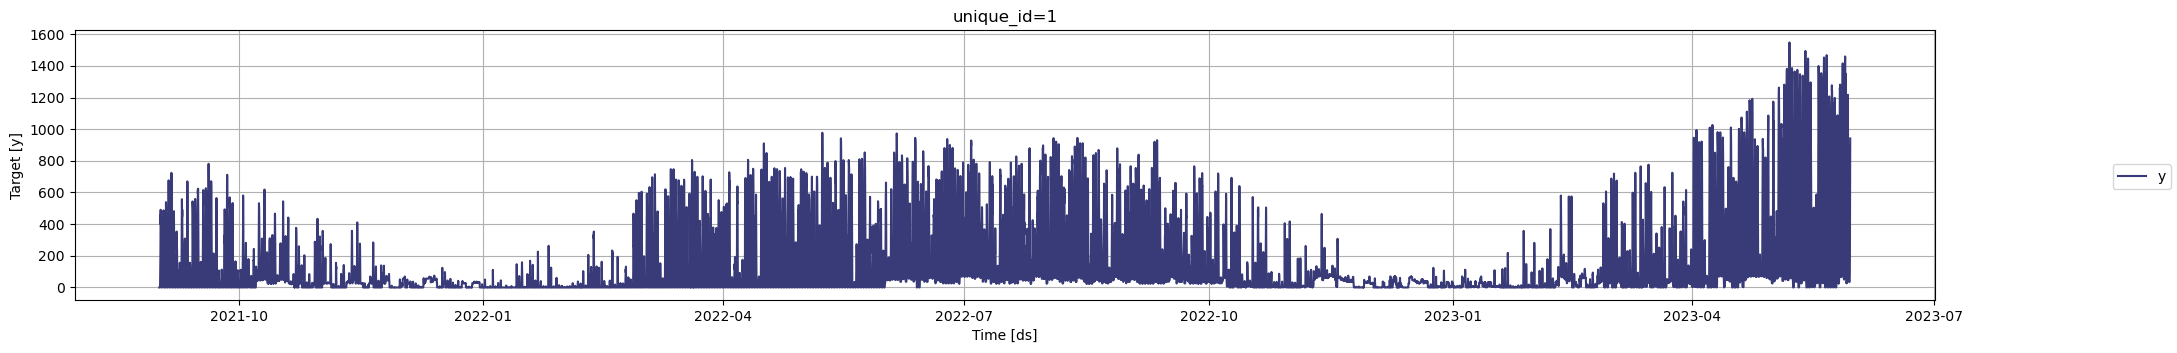

In [93]:
from statsforecast import StatsForecast

StatsForecast.plot(np_df1)

In [94]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series 
    trend_forecaster=AutoARIMA() # model used to forecast trend
)]

In [95]:
sf = StatsForecast(
    models=models, # model used to fit each time series 
    freq='H', # frequency of the data
)

In [96]:
sf = sf.fit(df=np_df1_train)

In [97]:
import matplotlib.pyplot as plt

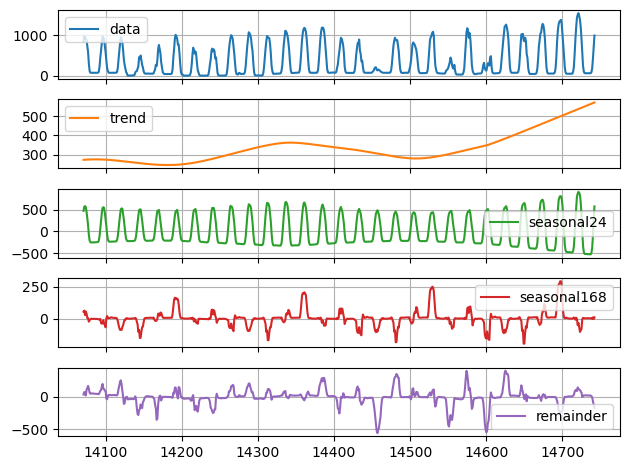

In [98]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

In [99]:
forecasts = sf.predict(h=24, level=[90], X_df=np_df1_test.drop('y', axis=1).head(24).reset_index(drop=True))
forecasts['y'] = np_df1_test.head(24)['y'].values
forecasts

,ds,MSTL,MSTL-lo-90,MSTL-hi-90,y
unique_id,,,,,
1,2023-05-08 11:00:00,1301.873291,1252.897217,1350.849487,1212.659
1,2023-05-08 12:00:00,1402.550537,1327.945190,1477.155884,1385.877
1,2023-05-08 13:00:00,1423.059937,1331.653809,1514.465942,1368.649
1,2023-05-08 14:00:00,1471.453247,1370.266235,1572.640137,1331.865
1,2023-05-08 15:00:00,1429.368164,1323.280273,1535.456055,1245.737
1,2023-05-08 16:00:00,1220.441284,1111.636353,1329.246216,1052.754
1,2023-05-08 17:00:00,885.817688,775.720276,995.915161,839.573
1,2023-05-08 18:00:00,441.305084,330.526093,552.084045,489.736
1,2023-05-08 19:00:00,121.611137,10.442410,232.779861,185.461


In [60]:
forecasts = sf.predict(h=24, level=[90], X_df=np_df1_test.drop('y', axis=1).head(24))
forecasts['y'] = np_df1_test.head(24)['y'].values
forecasts

,ds,MSTL,MSTL-lo-90,MSTL-hi-90,y
unique_id,,,,,
1,2023-04-30 11:00:00,603.514648,555.804077,651.225159,257.093
1,2023-04-30 12:00:00,580.261658,503.663147,656.860107,336.582
1,2023-04-30 13:00:00,621.640991,526.638733,716.643250,448.617
1,2023-04-30 14:00:00,701.610046,594.951477,808.268555,388.309
1,2023-04-30 15:00:00,668.281250,555.363953,781.198547,265.345
1,2023-04-30 16:00:00,454.608734,338.275574,570.941895,191.663
1,2023-04-30 17:00:00,265.732666,147.500137,383.965210,173.753
1,2023-04-30 18:00:00,174.017410,54.695621,293.339203,267.929
1,2023-04-30 19:00:00,60.936020,-59.040333,180.912384,121.221


In [61]:
from sklearn.metrics import mean_absolute_error

In [62]:
mean_absolute_error(forecasts.y, forecasts.MSTL)

155.9158402077357

In [78]:
mean_absolute_error(forecasts.y, forecasts.MSTL)

167.8024913562139

In [89]:
mean_absolute_error(forecasts.y, forecasts.MSTL)

87.09370835558575

In [100]:
mean_absolute_error(forecasts.y, forecasts.MSTL)

68.03149986775718